In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# def equation(x, y, f):
#     dy_xx = dde.grad.hessian(y, x)
#     return -dy_xx - f

def poisson_equation(xy,u,f):
    b = 1
    c = 1
    du_xx = dde.grad.hessian(u, xy, j=0)
    du_yy = dde.grad.hessian(u, xy, j=1)
    coef = -(1/(b*b)+1/(c*c))
    return du_xx + du_yy - coef*u

geom = dde.geometry.Rectangle([0, 0], [1, 1])

def func_ic(x, v):
    return v

def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

ic = dde.icbc.DirichletBC(geom, func_ic, boundary)

pde = dde.data.PDE(geom, poisson_equation, ic, num_domain=200, num_boundary=100,)

In [3]:
func_space = dde.data.GRF(kernel="ExpSineSquared", length_scale=1)

In [4]:
# Data
eval_pts = np.linspace(0, 1, num=50)[:, None]
data = dde.data.PDEOperatorCartesianProd(
    pde, func_space, eval_pts, 1000, function_variables=[0], num_test=100, batch_size=32
)

In [5]:
net = dde.nn.DeepONetCartesianProd(
    [50, 64, 64, 64],
    [2, 64, 64, 64],
    "tanh",
    "Glorot normal",
)

In [6]:
def periodic(x):
    x, y = x[:, :1], x[:, 1:]
    x = x * 2 * np.pi
    y = y * 2 * np.pi
    return torch.cat([x, y], 1)

net.apply_feature_transform(periodic)

In [7]:
model = dde.Model(data, net)
model.compile("adam", lr=0.0005)

Compiling model...
'compile' took 0.544071 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.10e+01, 1.16e+00]    [9.08e+00, 8.95e-01]    []  
1000      [1.90e-02, 2.63e-01]    [1.95e-02, 1.82e-01]    []  
2000      [1.91e-02, 1.73e-01]    [1.90e-02, 1.66e-01]    []  
3000      [1.17e-02, 1.66e-01]    [1.20e-02, 1.20e-01]    []  
4000      [9.15e-03, 8.11e-02]    [9.34e-03, 9.88e-02]    []  
5000      [1.17e-02, 9.26e-02]    [1.27e-02, 9.27e-02]    []  
6000      [5.25e-03, 7.04e-02]    [5.04e-03, 8.24e-02]    []  
7000      [1.21e-02, 4.98e-02]    [1.08e-02, 4.65e-02]    []  
8000      [3.20e-03, 3.27e-02]    [3.61e-03, 3.50e-02]    []  
9000      [1.09e-02, 2.97e-02]    [1.35e-02, 3.06e-02]    []  
10000     [1.92e-03, 1.38e-02]    [1.97e-03, 1.82e-02]    []  
11000     [3.19e-02, 2.16e-02]    [2.32e-02, 1.85e-02]    []  
12000     [6.87e-03, 1.51e-02]    [6.82e-03, 1.32e-02]    []  
13000     [4.07e-03, 9.76e-03]    [3.79e-03, 8

KeyboardInterrupt: 

Training model...

20553     [3.03e-03, 3.34e-03]    [3.22e-03, 3.22e-03]    []  
21000     [6.74e-04, 2.83e-03]    [7.05e-04, 3.00e-03]    []  
21553     [1.23e-03, 3.17e-03]    [1.25e-03, 3.62e-03]    []  

Best model at step 21000:
  train loss: 3.50e-03
  test loss: 3.70e-03
  test metric: []

'train' took 221.893512 s



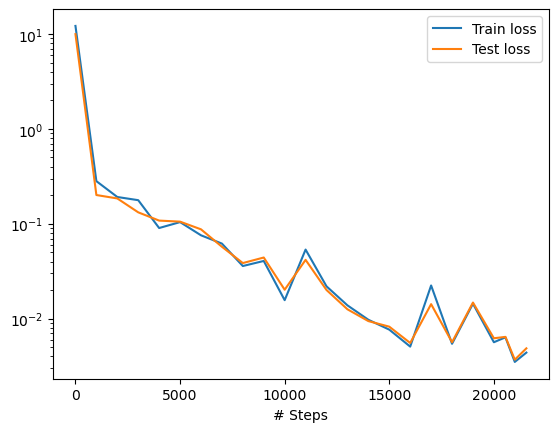

In [9]:
losshistory, train_state = model.train(iterations=1000)
dde.utils.plot_loss_history(losshistory)

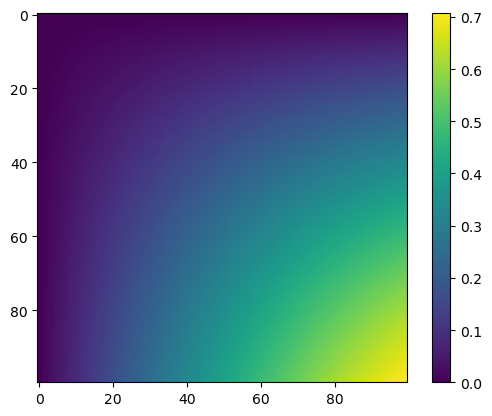

In [12]:
x = np.linspace(0, 1, num=100)
y = np.linspace(0, 1, num=100)
u_true = np.sin(x)*np.sin(y[:, None])
plt.figure()
plt.imshow(u_true)
plt.colorbar()

In [ ]:
v_branch = np.sin(2 * np.pi * eval_pts).T
xv, tv = np.meshgrid(x, t)
x_trunk = np.vstack((np.ravel(xv), np.ravel(tv))).T
u_pred = model.predict((v_branch, x_trunk))
u_pred = u_pred.reshape((100, 100))
plt.figure()
plt.imshow(u_pred)
plt.colorbar()
plt.show()
print(dde.metrics.l2_relative_error(u_true, u_pred))